# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=87d9a5c723abb361ec3c8fa19e79cdb1d21479dde812100c597f5765b78c9294
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate list

  competitionId  title                                                                             closing     prize        submitters
---------------  --------------------------------------------------------------------------------  ----------  ---------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                              7417
             24  【練習問題】お弁当の需要予測                                                      -                              9112
             27  【練習問題】Jリーグの観客動員数予測                                               -                              2287
            100  【練習問題】手書き文字認識                                                        -           Knowledge           398
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge          3408
            103  【練習問題】音楽ラベリング                                                        -           Knowledge           233
            

In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

2. データの読み込みと確認

    ・id: 顧客ID、・Age: 年齢、・TypeofContact: 連絡方法、
    ・CityTier: 都市層(1>2>3)、・DurationOfPitch: 売り込み時間
    ・Occupation: 職業、・Gender: 性別、・NumberOfPersonVisiting: 人数
    ・NumberOfFollowups: フォローアップ合計数、
    ・ProductPitched: 商品の売り込み、・PreferredPropertyStar: ホテルの優先評価
    ・NumberOfTrips: 年間旅行数、・Passport: パスポート所持
    ・PitchSatisfactionScore: 満足度スコア、・Designation: 顧客の指定
    ・MonthlyIncome: 月収
    ・customer_info: 顧客の情報のメモ(婚姻状況や車の有無、旅行の子どもの同伴の有無について記載されている)
    ・ProdTaken: 目的変数


In [ ]:
print(train.shape)
print(test.shape)

(3489, 18)
(3489, 17)


3. データの可視化

In [ ]:
# 出現数の確認
train["ProdTaken"].value_counts()

,count
ProdTaken,
0,2992
1,497


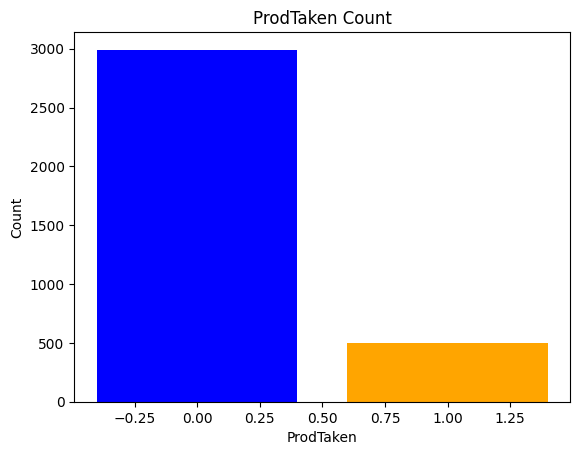

In [ ]:
# 成約数のグラフ
# 不均衡データであることがわかる
ProdTaken_value_counts = train["ProdTaken"].value_counts()
plt.bar(ProdTaken_value_counts.index, ProdTaken_value_counts.values, color=['blue', 'orange'])
plt.xlabel('ProdTaken')
plt.ylabel('Count')
plt.title('ProdTaken Count')
plt.show()

In [ ]:
# 成約成否にホテルの評価は関わらない
train.groupby("ProdTaken")["PreferredPropertyStar"].mean()

,PreferredPropertyStar
ProdTaken,
0,3.442513
1,3.432596


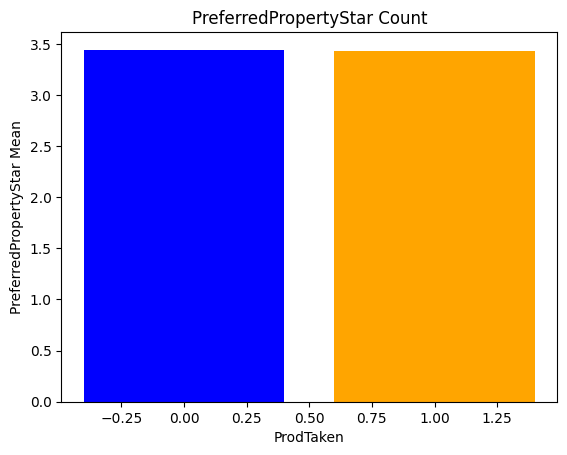

In [ ]:
# 成約成否にホテルの評価は関わらない
groupby_PreferredPropertyStar = train.groupby("ProdTaken")["PreferredPropertyStar"].mean()
plt.bar(groupby_PreferredPropertyStar.index, groupby_PreferredPropertyStar.values, color=['blue', 'orange'])
plt.xlabel('ProdTaken')
plt.ylabel('PreferredPropertyStar Mean')
plt.title('PreferredPropertyStar Count')
plt.show()

In [ ]:
# Large Businessの方が成約率が高い
train.groupby("Occupation")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)

,mean,count
Occupation,,
Small Business,0.157499,1727
Salaried,0.102070,1401
Large Business,0.227147,361


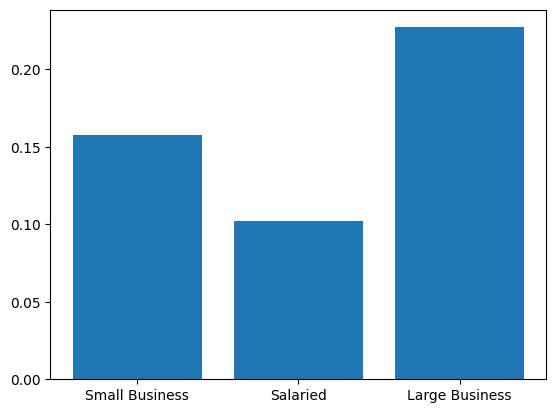

In [ ]:
# Large Businessの方が成約率が高い
grouped = train.groupby("Occupation")["ProdTaken"].agg(["mean", "count"]).sort_values(by="count", ascending=False)
plt.bar(grouped.index, grouped["mean"])
plt.show()

4. 前処理

In [ ]:
# 連絡方法と職業をダミー変数化
train = pd.get_dummies(train, columns=["TypeofContact", "Occupation"])
test = pd.get_dummies(test, columns=["TypeofContact", "Occupation"])

5. データの分割

In [ ]:
# 目的変数
target = train["ProdTaken"]

# カテゴリ変数を削除
train = train.drop(columns=['id', 'Age', 'DurationOfPitch', 'Gender', 'NumberOfFollowups', 'ProductPitched',
                            'NumberOfTrips', 'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'customer_info',
                            "ProdTaken"], axis=1)

test = test.drop(columns=['id', 'Age', 'DurationOfPitch', 'Gender', 'NumberOfFollowups', 'ProductPitched',
                          'NumberOfTrips', 'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'customer_info'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# 訓練データと評価データを3:1に分ける
X_train, X_valid, y_train, y_valid = train_test_split(train, target, random_state = 42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(2616, 9) (873, 9) (2616,) (873,)


6. 学習と検証

In [ ]:
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.metrics import roc_auc_score # AUC評価指標

In [ ]:
# 学習
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 予測
pred = model.predict_proba(X_valid)

In [ ]:
# 予測の中身を確認します
print(pred[:1])

[[0.88942315 0.11057685]]


In [ ]:
y_valid

,ProdTaken
295,0
2868,0
3374,0
1462,1
969,0
...,...
366,0
2166,0
2389,0
29,1


In [ ]:
pred[:,1]

array([0.11057685, 0.34989194, 0.07258392, 0.1173274 , 0.05781948,
       0.11751465, 0.12130273, 0.27195242, 0.09974482, 0.18236691,
       0.18236691, 0.11057685, 0.15810865, 0.04436002, 0.14918965,
       0.04466998, 0.3025    , 0.        , 0.17623844, 0.10270457,
       0.04466998, 0.29194444, 0.10468763, 0.15810865, 0.09974482,
       0.05964896, 0.20059825, 0.05781948, 0.10216586, 0.05781948,
       0.        , 0.12343808, 0.19735487, 0.15810865, 0.        ,
       0.43212915, 0.14918965, 0.        , 0.05600717, 0.1173274 ,
       0.10424147, 0.7419697 , 0.11057685, 0.17117522, 0.13063507,
       0.12545213, 0.04466998, 0.        , 0.08398847, 0.05600717,
       0.18236691, 0.04466998, 0.18236691, 0.09041012, 0.37863944,
       0.06213234, 0.        , 0.1181498 , 0.09041012, 0.08398847,
       0.025     , 0.        , 0.00230159, 0.09974482, 0.15810865,
       0.19786435, 0.09041012, 0.19786435, 0.35880227, 0.09041012,
       0.16703342, 0.23607222, 0.23969706, 0.05600717, 0.     

In [ ]:
# AUCの評価
score = roc_auc_score(y_valid, pred[:, 1])
print(score)

0.6376585475361993


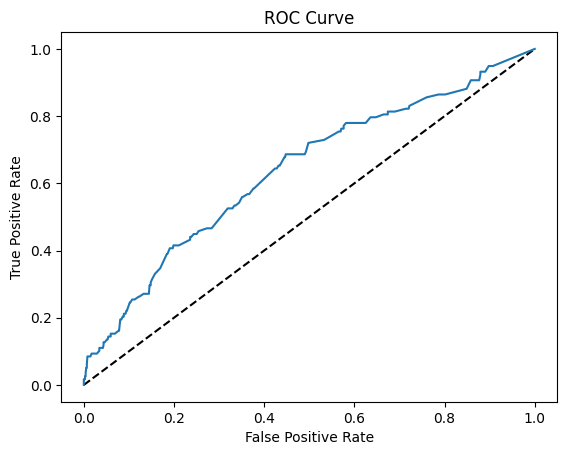

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict = model.predict_proba(test)
submit[1] = predict[:, 1]

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)


今後の方針

提出が完了したからといって、このコンペティションは終わりではありません。次のステップは、精度を改善することです。

では、どのようにして精度を向上させるのでしょうか？以下にいくつかのヒントを示します。
予測モデルを変更する

ランダムフォレスト以外にも、勾配ブースティングやロジスティック回帰などが存在します。どのモデルが最適かはデータによって異なるため、様々なモデルを試してみる価値があります。
予測モデルのパラメータを調整する

ランダムフォレストには様々なパラメータが存在します。例えば、max_depth(木の深さ)などがあります。これらのパラメータを変更して、予測性能がどう変化するかを確認してみましょう。

参考リンク: ランダムフォレストのパラメータ
予測に使用する特徴量を増やす

本データセットに存在する以下の特徴量はまだ使われていません。これらを追加してみるとどうなるでしょうか?

    ・Age
    ・DurationOfPitch
    ・Gender
    ・NumberOfFollowups
    ・ProductPitched
    ・NumberOfTrips
    ・Passport
    ・PitchSatisfactionScore
    ・Designation
    ・MonthlyIncome
    ・customer_info

データの前処理

このデータには前処理が必要です。生データをそのまま使用すると、人間が解釈するのと機械学習モデルが解釈するのとで異なる結果が出ることがあります。

例えばAgeの場合、"50歳"のデータが存在しますが、機械学習モデルでは"50歳"というカテゴリデータで解釈されます。年齢は大きければ大きいほど、成約に影響を与えるかもしれませんが、カテゴリデータではその大きさを比較できません。このためAgeをカテゴリデータから数値に直す必要があるかもしれません。
Genderなどの一部特徴量の違和感の確認

Genderの場合、全角や大文字が混在しています。

例えば、機械学習ではfemaleとFemaleは異なるデータとして扱われますが、これは正しい扱い方でしょうか?この点を確認してみましょう。
